# Exercise 2
In this notebook I will perform the exercises from the course using Python 3.

## Logistic regression
In this part of the exercise, you will build a logistic regression model to
predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant’s scores on two exams and the admissions
decision.

Your task is to build a classification model that estimates an applicant’s
probability of admission based the scores from those two exams.

In [133]:
# libraries
# data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
# fit parameters
import scipy as sp
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

In [40]:
# import first dataset
dat = pd.read_csv('ex2/ex2data1.txt',header=None)
dat.columns = ['exam_1','exam_2','decision']
dat.head()

,exam_1,exam_2,decision
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## Data visualization

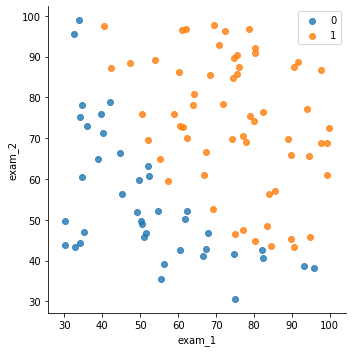

In [41]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="exam_1", y="exam_2", data=dat, fit_reg=False, hue='decision', legend=False)

# Move the legend to an empty part of the plot
plt.legend(loc='upper right')
plt.show()

## Implementation

### Warm-up: sigmoid function

$$h_\theta(x)=\frac{1}{1+\exp^{-\theta^Tx}}$$

Define the sigmoid function to call it from the rest of the notebook.

In [42]:
def sgmd(x_values,pars):
    return (1)/(1+np.exp(-(np.array(pars).dot(np.array(x_values).T))))

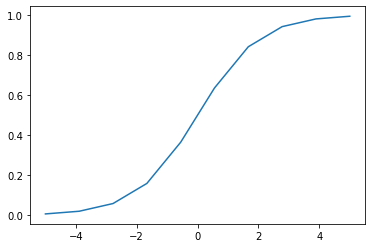

In [43]:
# visualize
plt.plot(np.linspace(-5,5,10),sgmd(np.linspace(-5,5,10),1))
plt.show()

### Cost function and gradient
Now implement the cost function and gradient for logistic regression.

Recall that the cost function is:

$$J(\theta)=-\frac{1}{m}[\sum_{i=1}^{m}y^{(i)}log(h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)}))]$$

You should see that the cost is about 0.693.

In [44]:
# define cost function
def log_cost_function(x_values,pars,y_values):
    # transform variables
    y_values=np.array(y_values)
    
    # compute sigmoid function
    y_pred = sgmd(x_values,pars)
    
    # compute cost
    o_cost = (1/len(x_values))*np.sum((-y_values*np.log(y_pred))-((1-y_values)*np.log(y_pred)))
    return o_cost

In [45]:
# initialize
X = np.c_[np.ones(len(dat)),dat[['exam_1','exam_2']]]
Y = np.array(dat['decision'])
theta = np.array([[0,0,0]])

In [46]:
# test function
log_cost_function(X,theta,Y)

0.6931471805599453

### Learning parameters

In the original exercise, the author implements the function `fminunc` from MATLAB.

- Gradient descent

I will implement my previous function to perform gradient descent for 400 iterations and $\alpha=0.0001$.

You should see that the cost is about
0.203.
This final $\theta$ value will then be used to plot the decision boundary on the
training data

In [47]:
# function for simultaneous parameter update
def gradient_descent(x_values,pars,y_values,l_rate,n_iterations):
    cost = []
    
    # compute and save cost
    cost.append(log_cost_function(x_values,pars,y_values))
        
    pars_list = [pars]
    for i in range(n_iterations):
        # update parameters
        pars = compute_gradient(x_values,pars,y_values,l_rate)
        pars_list.append(pars)
        
        # compute and save cost
        cost.append(log_cost_function(x_values,pars,y_values))
        
    return [cost,pars_list]

# function to compute step gradient
def compute_gradient(x_values,pars,y_values,l_rate):
    # compute difference from linear model to y_values
    obs_er = (sgmd(x_values,pars)-y_values)
    
    # compute new theta values
    theta_new = pars - l_rate*(1/len(y_values))*obs_er.dot((x_values))
    return theta_new

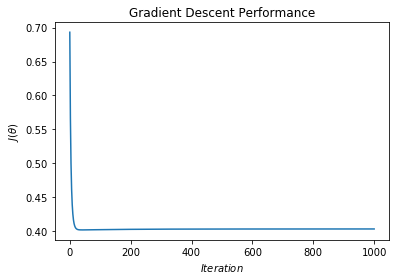

[[-0.00690431  0.01047156  0.00050671]]


In [48]:
# gd parameters
alpha = 0.0001
iterations = 1000

# perform gradient descent
gd_result = gradient_descent(X,theta,Y,alpha,iterations)

# visualize performance
plt.plot(gd_result[0])
plt.title('Gradient Descent Performance')
plt.ylabel(r'$J(\theta)$')
plt.xlabel(r'$Iteration$')

plt.show()

# optimal parameters
pars_gd = gd_result[1][-1]
print(pars_gd)

In [49]:
gd_result[0][-1]

0.40308114721708244

I did not get to the expected cost.
Most likely, due to getting stuck into a local minimum.

- Using `fmin_tnc` from Python:

Solution from: https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24

In [54]:
# hypothesis function
def sigmoid(theta,x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-theta.dot(x.T)))

# cost function
def cost_function(theta, x, y):
    # Computes the cost function for all the training samples
    m = x.shape[0]
    total_cost = -(1 / m) * np.sum(
        y * np.log(sigmoid(theta, x)) + (1 - y) * np.log(1 - sigmoid(theta, x)))
    return total_cost

# jacobian (partial derivative of cost function)
def gradient(theta, x, y):
    # Computes the gradient of the cost function at the point theta
    m = x.shape[0]
    return (1 / m) * np.dot(x.T, sigmoid(theta,   x) - y)

# optimization of cost function
def opt_weights(x, y, theta):
    opt_weights = sp.optimize.fmin_tnc(func=cost_function, x0=theta,
                  fprime=gradient,args=(x, y.flatten()))
    return opt_weights[0]

In [55]:
pars_min = opt_weights(X,Y,theta)
pars_min

array([-25.16131865,   0.20623159,   0.20147149])

### Evaluating logistic regression

#### Probability

After learning the parameters, you can use the model to predict whether a
particular student will be admitted. For a student with an Exam 1 score
of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776.

In [15]:
# probability
test_p = np.array([1,45,85])
sgmd(test_p,pars_gd)

array([0.62419361])

In [16]:
# probability
test_p = np.array([1,45,85])
sgmd(test_p,pars_min)

0.7762906229081791

#### Plotting Decision Boundary
As there are two features in our dataset, the linear equation can be represented by,

$$h(x)=\theta_0+\theta_1 x_1+\theta_2 x_2$$

As discussed earlier, the decision boundary can be found by setting the weighted sum of inputs to 0. Equating h(x) to 0 gives us,

$$x_2 = - \frac{\theta_0+\theta_1 x_1}{\theta_2}$$

We will plot our decision boundary on top of the plot we used for visualizing our dataset.

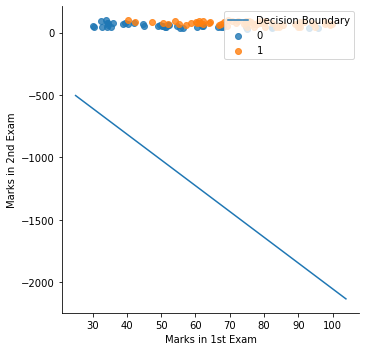

In [17]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot(x="exam_1", y="exam_2", data=dat, fit_reg=False, hue='decision', legend=False)

# add decision boundary
x_db = [np.min(X[:, 1] - 5), np.max(X[:, 2] + 5)]
y_db = - (pars_gd[0,0] + np.dot(pars_gd[0,1], x_db)) / pars_gd[0,2]

# Move the legend to an empty part of the plot
plt.plot(x_db, y_db, label='Decision Boundary')
plt.xlabel('Marks in 1st Exam')
plt.ylabel('Marks in 2nd Exam')
plt.legend(loc='upper right')
plt.show()

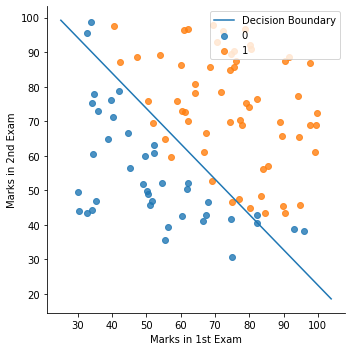

In [18]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot(x="exam_1", y="exam_2", data=dat, fit_reg=False, hue='decision', legend=False)

# add decision boundary
x_db = [np.min(X[:, 1] - 5), np.max(X[:, 2] + 5)]
y_db = - (pars_min[0] + np.dot(pars_min[1], x_db)) / pars_min[2]

# Move the legend to an empty part of the plot
plt.plot(x_db, y_db, label='Decision Boundary')
plt.xlabel('Marks in 1st Exam')
plt.ylabel('Marks in 2nd Exam')
plt.legend(loc='upper right')
plt.show()

With a simple gradient descent it is difficult to obtain the optimal parameters while using other parameter fitting functions increases dramatically the performance.

## Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA). 

During QA, each microchip goes through various tests to ensure
it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. 

From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. 

To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

In [242]:
# import second dataset
df = pd.read_csv('ex2/ex2data2.txt',header=None)
df.columns = ['test_1','test_2','decision']
df.head()

,test_1,test_2,decision
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### Visualizing data

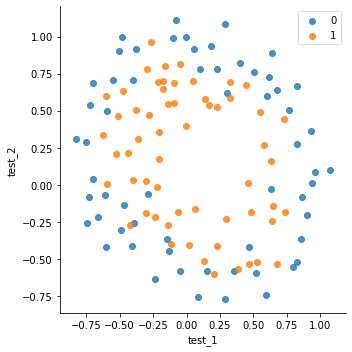

In [243]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="test_1", y="test_2", data=df, fit_reg=False, hue='decision', legend=False)

# Move the legend to an empty part of the plot
plt.legend(loc='upper right')
plt.show()

### Feature Mapping
One way to fit the data better is to create more features from each data
point. We will map the features into
all polynomial terms of x1 and x2 up to the sixth power.
As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. 

A logistic
regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier,
it also more susceptible to overfitting. In the next parts of the exercise, you
will implement regularized logistic regression to fit the data and also see for
yourself how regularization can help combat the overfitting problem.

In [244]:
# polynomial transformation up to 6th degree
poly = PolynomialFeatures(6)
X = poly.fit_transform(df[['test_1','test_2']])
print(X)

[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01 ...  6.29470940e-04
   8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01 ...  1.89305413e-03
  -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.92250000e-01 ...  1.04882142e-02
  -3.39734512e-02  1.10046893e-01]
 ...
 [ 1.00000000e+00 -4.84450000e-01  9.99270000e-01 ...  2.34007252e-01
  -4.82684337e-01  9.95627986e-01]
 [ 1.00000000e+00 -6.33640000e-03  9.99270000e-01 ...  4.00328554e-05
  -6.31330588e-03  9.95627986e-01]
 [ 1.00000000e+00  6.32650000e-01 -3.06120000e-02 ...  3.51474517e-07
  -1.70067777e-08  8.22905998e-10]]


In [245]:
# prepare the rest of the data
Y = np.array(df['decision'])

### Cost function and gradient
Now you will implement code to compute the cost function and gradient for
regularized logistic regression.
Note that you should not regularize the parameter $\theta_0$.
Once you are done, you should see that the
cost is about 0.693.

In [246]:
# re-write regularized functions

# cost function
def reg_cost_function(theta, x, y,lbda):
    """
    Computes the cost function for all the training samples
    """
    m = x.shape[0]
    total_cost = -(1 / m)*np.sum(y*np.log(sigmoid(theta, x))+(1-y)*np.log(1-sigmoid(theta,x)))+(lbda/(2*m))*np.sum(theta[1:]**2)
    return total_cost

# jacobian (partial derivative of cost function)
def reg_gradient(theta, x, y,lbda):
    """
    Computes the gradient (J) of the cost function with parameters theta, input variables x,
    output variable y and regularization term lbda (only when j>0)
    """
    m = x.shape[0]
    
    J_0 = np.array([(1 / m)*np.dot(x.T,sigmoid(theta,x)-y)[0]])
    J_1 = (1 / m)*np.dot(x.T,sigmoid(theta,x)-y)[1::]+(lbda/m)*theta[1::]
    
    return np.append(J_0,J_1)
    
# optimization of cost function using predefined function
def reg_opt_weights(theta,x,y,lbda):
    """
    Optimizes theta
    """
    
    opt_weights = sp.optimize.fmin_tnc(func=reg_cost_function, x0=theta,
                  fprime=reg_gradient,args=(x, y.flatten(),lbda))
    
    return opt_weights[0]

# optimization of cost function using gradient descent
def reg_gradient_descent(theta,x,y,lbda,l_rate,n_iterations):
    """
    Optimizes parameters vector, theta, through gradient descent.
    """
    # initialize costs history vector
    cost = []
    # compute and save initial cost
    cost.append(reg_cost_function(theta, x, y,lbda))
    # initialize and save parameters   
    pars_list = [theta]
    
    
    for i in range(n_iterations):
        
        # compute new theta values
        theta_new = theta - l_rate*reg_gradient(theta,x,y,lbda) 
        # save
        pars_list.append(theta_new)
        
        # compute and save cost
        cost.append(reg_cost_function(theta_new, x, y,lbda))
        
    return [cost,pars_list]

In [247]:
# Hyperparameters
theta = np.zeros(X.shape[1])
lbda = 1
l_rate = 1
n_iterations = 400

In [140]:
# Optimize logistic model through predefined minimization function: fmin_tnc

# find optimal parameters
pars_minreg = reg_opt_weights(theta,X,Y,lbda)
print(pars_minreg)

# compute regularized cost function for these parameters
reg_cost_function(pars_minreg,X,Y,lbda)

[ 1.25441462  0.62276772  1.19242771 -2.00505494 -0.8729068  -1.3618424
  0.12573807 -0.35536833 -0.35603636 -0.17096368 -1.45784668 -0.06683329
 -0.61498644 -0.25080273 -1.18096078 -0.22566846 -0.20562893 -0.06382345
 -0.27187031 -0.27658989 -0.46836116 -1.03247374  0.01627584 -0.29695281
  0.00581071 -0.32631647 -0.12073372 -0.93023143]


0.5357749495485528

In [141]:
# Optimize logistic model through gradient descent

# find optimal parameters
pars_gdreg = reg_gradient_descent(theta,X,Y,lbda,l_rate,n_iterations)
print(pars_gdreg[1][-1])

# compute regularized cost function for these parameters
reg_cost_function(pars_gdreg[1][-1],X,Y,lbda)

[-8.47457627e-03 -1.87880932e-02 -7.77711864e-05 -5.03446395e-02
 -1.15013308e-02 -3.76648474e-02 -1.83559872e-02 -7.32393391e-03
 -8.19244468e-03 -2.34764889e-02 -3.93486234e-02 -2.23923907e-03
 -1.28600503e-02 -3.09593720e-03 -3.93028171e-02 -1.99707467e-02
 -4.32983232e-03 -3.38643902e-03 -5.83822078e-03 -4.47629067e-03
 -3.10079849e-02 -3.10312442e-02 -1.09740238e-03 -6.31570797e-03
 -4.08503006e-04 -7.26504316e-03 -1.37646175e-03 -3.87936363e-02]


0.6812915551427071

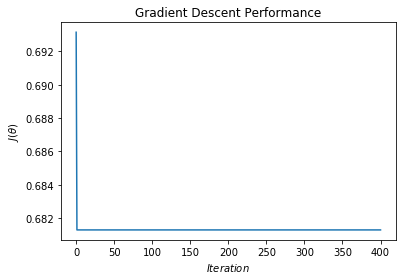

In [142]:
# visualize performance
plt.plot(pars_gdreg[0])
plt.title('Gradient Descent Performance')
plt.ylabel(r'$J(\theta)$')
plt.xlabel(r'$Iteration$')

plt.show()

The `fmin_tnc` (truncated Newton algorithm: https://en.wikipedia.org/wiki/Truncated_Newton_method) function performs better than gradient descent.

### Plotting decision boundary
To help you visualize the model learned by this classifier to plot (non-linear) decision boundary separates the positive and negative examples. We plot the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then draw
a contour plot of where the predictions change from y = 0 to y = 1.

Take into account that we can predict y through:

$$y=h_\theta(x)=\theta^TX$$

In [215]:
def predict_log_model(theta,x_values,degree):
    """
    Predict y of the model given set of parameters, theta, and variables, x, with a polynomial
    mapping of a certain degree.
    """
    # transform data
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(x_values)
    
    # predict values
    return sigmoid(theta,X)

In [252]:
def plot_boundaries(pars_opt,title_str):
    # Use trained logistic model to compute 
    xx1,xx2 = np.linspace(-1,1,100), np.linspace(-1,1,100)

    # parameters
    degree = 6

    # compute prices for all grid given the optimized parameters
    yy = np.zeros((xx1.shape[0],xx2.shape[0]))
    for i in range(len(xx1)):
        for j in range(len(xx2)):
            xx_grid = np.array([[xx1[i],xx2[j]]])
            yy[i,j] = predict_log_model(pars_opt,xx_grid,degree)

    # Use the 'hue' argument to provide a factor variable
    sns.lmplot( x="test_1", y="test_2", data=df, fit_reg=False, hue='decision', legend=False)

    # Move the legend to an empty part of the plot
    plt.legend(loc='upper right')

    plt.contour(xx1,xx2,yy)
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.title(title_str)
    plt.show()

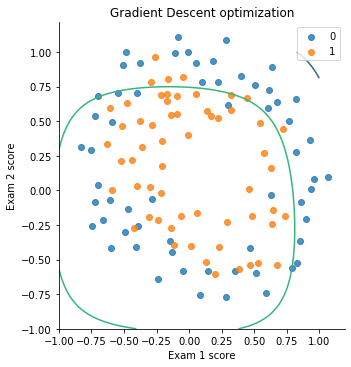

In [239]:
plot_boundaries(pars_gdreg_opt,'Gradient Descent optimization')

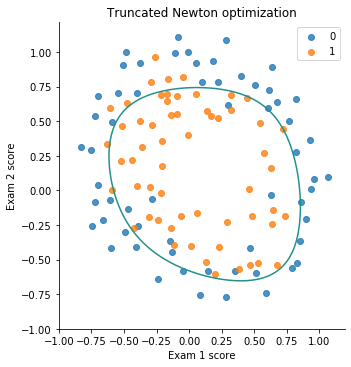

In [240]:
plot_boundaries(pars_minreg_opt,'Truncated Newton optimization')

### Changing $\lambda$

In this part of the exercise, you will get to try out different regularization
parameters for the dataset to understand how regularization prevents overfitting.
Notice the changes in the decision boundary as you vary λ. With a small
λ, you should find that the classifier gets almost every training example
correct, but draws a very complicated boundary, thus overfitting the data
(Figure 5). This is not a good decision boundary: for example, it predicts
that a point at x = (−0.25, 1.5) is accepted (y = 1), which seems to be an
incorrect decision given the training set.
With a larger λ, you should see a plot that shows an simpler decision
boundary which still separates the positives and negatives fairly well. However, if λ is set to too high a value, you will not get a good fit and the decision
boundary will not follow the data so well, thus underfitting the data (Figure
6).

In [136]:
# polynomial transformation up to 6th degree
poly = PolynomialFeatures(6)
X = poly.fit_transform(df[['test_1','test_2']])
print(X)

[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01 ...  6.29470940e-04
   8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01 ...  1.89305413e-03
  -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.92250000e-01 ...  1.04882142e-02
  -3.39734512e-02  1.10046893e-01]
 ...
 [ 1.00000000e+00 -4.84450000e-01  9.99270000e-01 ...  2.34007252e-01
  -4.82684337e-01  9.95627986e-01]
 [ 1.00000000e+00 -6.33640000e-03  9.99270000e-01 ...  4.00328554e-05
  -6.31330588e-03  9.95627986e-01]
 [ 1.00000000e+00  6.32650000e-01 -3.06120000e-02 ...  3.51474517e-07
  -1.70067777e-08  8.22905998e-10]]


In [248]:
def opt_and_pred(lbda):
    """
    Find optimal parameters for logistic regression and plot results for each value of lbda.
    """
    # data preparation
    poly = PolynomialFeatures(6)
    X = poly.fit_transform(df[['test_1','test_2']])
    Y = np.array(df['decision'])
    theta = np.zeros(X.shape[1])
    
    # find optimal parameters
    par_opt = reg_opt_weights(theta,X,Y,lbda)
    
    # plot boundary 
    plot_boundaries(par_opt,'')

Testing different $\lambda$ values:

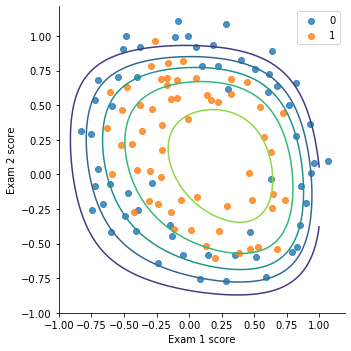

In [253]:
opt_and_pred(1)

/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/miquel/miniconda3/envs/ml_exercises/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWar

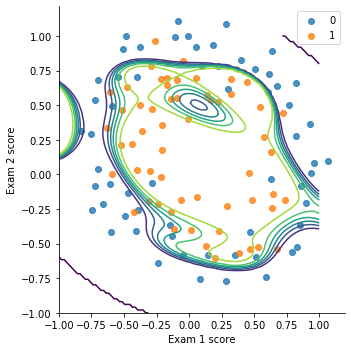

In [254]:
opt_and_pred(0) # overfitting

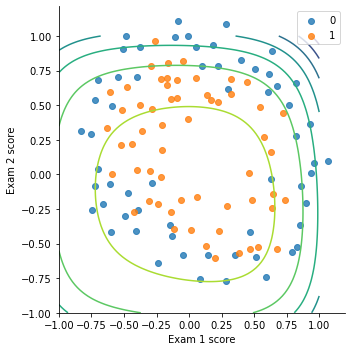

In [255]:
opt_and_pred(100) # underfitting